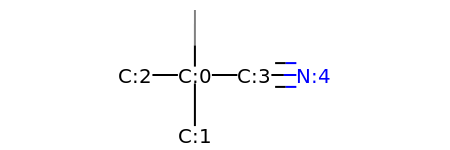

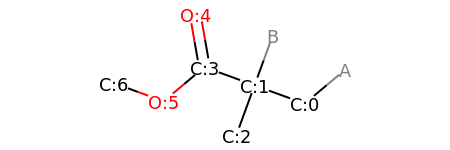

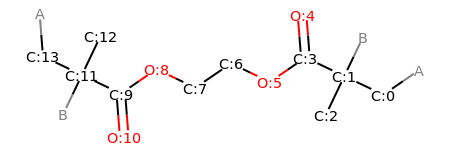

In [9]:
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import SVG, display
from rdkit import Chem
from rdkit.Chem.Draw import rdMolDraw2D
#from molNet.mol.molecules import to_graph_input

from molNet.mol.polymer import Polymer, TerminalGroup, RepatingUnit

tg = TerminalGroup(Chem.MolFromSmiles("[C](C)(C)C#N"),connection_indices=[0],connection_names=["I"],name="ini")
display(tg.get_mol(with_numbers=True))

ru=RepatingUnit(Chem.MolFromSmiles("[CH2][C](C)C(=O)OC"),connection_indices=[0,1],connection_names=["A","B"],name="ru")

display(ru.get_mol(with_numbers=True))

cl=RepatingUnit(Chem.MolFromSmiles("[CH2][C](C)C(=O)OCCOC(=O)[C](C)[CH2]"),connection_indices=[0,1,11,13],connection_names=["A","B","B","A"],name="cl")

display(cl.get_mol(with_numbers=True))

In [10]:
p = Polymer()
p.starting_group = tg
p.add_repeating_unit(ru)
p.add_repeating_unit(cl, ratio=0.000)
p.mn=2*10**4

p.connection_map={
    "I":["A","B"],
    "A":["B"]
}

#p.get_random_mol()
g=p.get_random_graph()

#%load_ext line_profiler
#print(len(g),m.nbytes)
#%lprun -f p.get_random_graph p.get_random_graph()

/home/julian/IdeaProjects/molNet/molNet/mol/polymer.py:186: UserWarning: ratio for '{}' is {}, which is not really expected
  warnings.warn("ratio for '{}' is {}, which is not really expected")


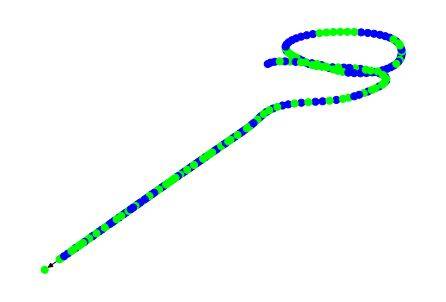

In [11]:
#nx.nx_pylab.draw_spring(g,with_labels=True,labels={i:g.nodes[i]['label'] for i in g.nodes },node_size=50)
color_map = []
import  numpy as np
nn = len(g)
cp=[(0,0,1),(0,1,0)]
ci = np.arange(len(cp))
for i,node in enumerate(g):
    p = i/nn

    c = cp[np.random.choice(ci,p=[1-p,p])]
    color_map.append(c)

nx.nx_pylab.draw(
    g,
    pos=nx.nx_pylab.spring_layout(g,
        pos=nx.nx_pylab.circular_layout(g)
    ,iterations=300),
    with_labels=False,labels={i:g.nodes[i]['label'] for i in g.nodes },
    node_color=color_map,
    node_size=50)

[0, 59, 63, 159, 42, 27, 123, 167, 36, 24, 200, 51, 127, 15, 126, 119, 81, 108, 33, 58, 72, 64, 148, 14, 35, 60, 128, 196, 166, 154, 23, 41, 90, 146, 150, 98, 183, 169, 68, 111, 20, 12, 66, 125, 86, 7, 165, 199, 73, 172, 198, 190, 67, 8, 71, 106, 11, 46, 77, 175, 163, 56, 144, 139, 97, 88, 4, 43, 112, 107, 191, 149, 129, 65, 13, 104, 55, 117, 19, 2, 79, 151, 145, 10, 137, 29, 53, 47, 93, 100, 5, 174, 171, 69, 95, 96, 120, 75, 158, 94, 184, 31, 76, 136, 37, 133, 61, 138, 180, 9, 118, 99, 147, 116, 52, 182, 113, 187, 1, 162, 122, 45, 44, 87, 156, 3, 49, 155, 195, 115, 54, 103, 80, 82, 40, 153, 193, 177, 6, 179, 57, 130, 30, 181, 101, 62, 102, 26, 17, 48, 50, 121, 140, 83, 114, 109, 38, 78, 134, 170, 173, 18, 185, 89, 197, 28, 39, 25, 160, 161, 92, 91, 21, 34, 178, 132, 188, 142, 131, 124, 85, 152, 32, 16, 141, 84, 74, 143, 168, 176, 189, 110, 192, 105, 186, 157, 22, 194, 164, 70, 135]
[0.0, 0.115, 0.885]


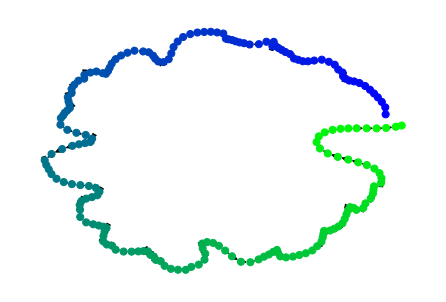

In [12]:
def moving_average(a, n=100) :
    #display(a)
    shape=np.array(a).shape
    ret = np.cumsum(a, dtype=float,axis=0)
    ret[n:] = ret[n:] - ret[:-n]
    for i in range(1,n):
        ret[i]=ret[i] / (i+1)
    ret[n:] = ret[n:] / n
    return ret

def grad(c1,c2,n):
    c = np.zeros(shape=(n,3))
    c[:,0]=np.linspace(c1[0],c2[0],n)
    c[:,1]=np.linspace(c1[1],c2[1],n)
    c[:,2]=np.linspace(c1[2],c2[2],n)
    return c
#display(moving_average(color_map))

def sorty_by_edges(g,to_sort):
    sorted=[]
    sorted_eges=[]
    all_edges= list(g.edges()).copy()

    def pop_next_edge(e=None):
        if e is None:
            return all_edges.pop(0),0
        for i,ed in enumerate(all_edges):
            if ed[0] == e[1]:
                return all_edges.pop(i),i
        return all_edges.pop(0),0

    e,i = pop_next_edge()
    sorted.append(i+len(sorted_eges))
    sorted_eges.append(e)
    for _ in range(len(all_edges)+4):
        e,i = pop_next_edge(sorted_eges[-1])
        sorted.append(i+len(sorted_eges))
        sorted_eges.append(e)
        if len(all_edges) == 0:
            break

    sorted_nodes = []
    for s,e in sorted_eges:
        if s not  in sorted_nodes:
            sorted_nodes.append(s)
        if e not  in sorted_nodes:
                sorted_nodes.append(e)
    for n in g:
        if n not  in sorted_nodes:
            sorted_nodes.append(n)


    sorted_node_indices=[]
    nodearray=np.array(g)
    for n in sorted_nodes:
        sorted_node_indices.append(np.argmin(np.abs(nodearray-n)))

    print(sorted_node_indices)
    return np.array(to_sort)[sorted_node_indices].tolist()

print(sorty_by_edges(g,grad(*cp,nn).tolist())[30])
g2=nx.DiGraph()
for i in range(len(g)):
    g2.add_node(i)
    if i>0:
        g2.add_edge(i-1,i)
nx.nx_pylab.draw(
    g2,
    pos=nx.nx_pylab.spring_layout(g2,
        pos=nx.nx_pylab.circular_layout(g2)
    ,iterations=30),
    with_labels=False,labels={i:g.nodes[i]['label'] for i in g.nodes },
    node_color=grad(*cp,nn).tolist(),
    node_size=50)

In [13]:
grad(*cp,nn)

array([[0.   , 0.   , 1.   ],
       [0.   , 0.005, 0.995],
       [0.   , 0.01 , 0.99 ],
       [0.   , 0.015, 0.985],
       [0.   , 0.02 , 0.98 ],
       [0.   , 0.025, 0.975],
       [0.   , 0.03 , 0.97 ],
       [0.   , 0.035, 0.965],
       [0.   , 0.04 , 0.96 ],
       [0.   , 0.045, 0.955],
       [0.   , 0.05 , 0.95 ],
       [0.   , 0.055, 0.945],
       [0.   , 0.06 , 0.94 ],
       [0.   , 0.065, 0.935],
       [0.   , 0.07 , 0.93 ],
       [0.   , 0.075, 0.925],
       [0.   , 0.08 , 0.92 ],
       [0.   , 0.085, 0.915],
       [0.   , 0.09 , 0.91 ],
       [0.   , 0.095, 0.905],
       [0.   , 0.1  , 0.9  ],
       [0.   , 0.105, 0.895],
       [0.   , 0.11 , 0.89 ],
       [0.   , 0.115, 0.885],
       [0.   , 0.12 , 0.88 ],
       [0.   , 0.125, 0.875],
       [0.   , 0.13 , 0.87 ],
       [0.   , 0.135, 0.865],
       [0.   , 0.14 , 0.86 ],
       [0.   , 0.145, 0.855],
       [0.   , 0.15 , 0.85 ],
       [0.   , 0.155, 0.845],
       [0.   , 0.16 , 0.84 ],
       [0.

In [14]:
if len(g)<10**2:
    mol,data = p.get_random_mol(g,highlight_units=True)


    d=rdMolDraw2D.MolDraw2DSVG(300, 300)


    rdMolDraw2D.PrepareAndDrawMolecule(d,
                                       mol,
                                       highlightAtoms=data['highlight_atoms'].keys(),
                                       highlightAtomColors=data['highlight_atoms'],
                                       highlightBonds=data['highlight_bonds'].keys(),
                                       highlightBondColors=data['highlight_bonds']
                                      )
    plt.show()
    d.FinishDrawing()
    display(SVG(d.GetDrawingText()))

In [15]:
g.nodes[0]


{'unit': <molNet.mol.polymer.TerminalGroup at 0x7f84a5deab10>,
 'label': 'ini',
 'free_conenctions': ['I']}

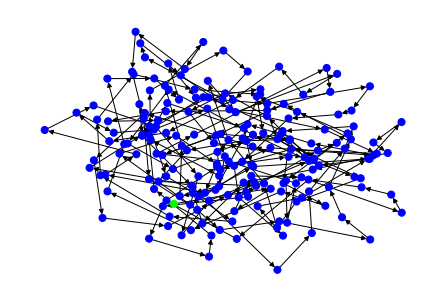

In [16]:
from molNet.featurizer.polymer import number_of_connections
g.featurize(featurizer=number_of_connections)
colors=[
    (1,0,0),
    (0,1,0),
    (0,0,1),
    (1,1,0),
    (1,0,1),
    (0,1,1),
]
for n in g.nodes:
    node = g.nodes[n]
    node["color"]=colors[node['molNet_features'][0]]

_colors = [g.nodes[n]['color'] for n in g.nodes]
nx.nx_pylab.draw(g,nx.spring_layout(g,iterations=10),
                 with_labels=False,
                               node_color=_colors,
                              labels={i:g.nodes[i]['label'] for i in g.nodes },node_size=50)